In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler

import os
import yaml
from tqdm.notebook import tqdm
import wandb
from typing import Dict, List, Tuple
import gc

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the data

In [2]:
## Defining the path
train_data_path = "./dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv"
test_data_path = "./dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv"
val_data_path = "./dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv"

In [3]:
## Loading the train, test, val data
train_data_list = []
with open(train_data_path, encoding='utf-8') as f:
        for line in f:
            native, roman, freq = line.strip().split('\t')
            train_data_list.append((native, roman, freq))

print(f"Number of training examples: {len(train_data_list)}")

test_data_list = []
with open(test_data_path, encoding="utf-8") as f:
      for line in f:
            native, roman, freq = line.strip().split('\t')
            test_data_list.append((native, roman, freq))

print(f"Number of test examples: {len(test_data_list)}")

val_data_list = []
with open(val_data_path, encoding="utf-8") as f:
      for line in f:
            native, roman, freq = line.strip().split('\t')
            val_data_list.append((native, roman, freq))

print(f"Number of val examples: {len(val_data_list)}")

Number of training examples: 68218
Number of test examples: 6864
Number of val examples: 6827


In [4]:
train_df = pd.DataFrame(train_data_list, columns=["native", "roman", "freq"])
test_df = pd.DataFrame(test_data_list, columns=["native", "roman", "freq"])
val_df = pd.DataFrame(val_data_list, columns=["native", "roman", "freq"])

print(f"checking the length of the characters in native language : ")
display(train_df["native"].str.len().describe())

print(f"checking the length of the characters in roman : ")
display(train_df["roman"].str.len().describe())

""" Using only terms with top frequency in test for producing test acccuracy """
unique_test = test_df['native'].unique()
test_df = test_df.loc[test_df.groupby('native')['freq'].idxmax()][['native', 'roman', 'freq']].reset_index(drop=True)

train_df.sample(5)

checking the length of the characters in native language : 


count    68218.000000
mean         8.838327
std          3.385477
min          1.000000
25%          6.000000
50%          8.000000
75%         11.000000
max         26.000000
Name: native, dtype: float64

checking the length of the characters in roman : 


count    68218.000000
mean        10.113504
std          3.920229
min          1.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         30.000000
Name: roman, dtype: float64

,native,roman,freq
53276,பொருந்திய,porundhdhiya,1
6688,இணைந்துள்ளன,inaindhullana,1
32181,ஜாக்கி,jackey,1
45078,படிப்பதில்,padippadhil,1
25021,சகோதரருடன்,chakoothararutan,1


In [5]:
print(f"checking the length of the characters in native language (val data) : ")
display(val_df["native"].str.len().describe())

print(f"checking the length of the characters in roman (val data): ")
display(val_df["roman"].str.len().describe())

val_df.sample(5)

checking the length of the characters in native language (val data) : 


count    6827.000000
mean        8.222352
std         3.174080
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        20.000000
Name: native, dtype: float64

checking the length of the characters in roman (val data): 


count    6827.000000
mean        9.494507
std         3.696724
min         1.000000
25%         7.000000
50%         9.000000
75%        12.000000
max        23.000000
Name: roman, dtype: float64

,native,roman,freq
2889,சுகந்தன்,suganthan,2
1098,உள்ளீடுகள்,ulleedukal,2
3861,துவக்கப்பட்ட,thuvakkappatta,3
1997,கிடைக்கும்போது,kidaikkumpothu,1
2577,சங்கத்திலிருந்து,sanggaththilirunthu,1


### Building vocab

In [6]:
unique_words_train = set(train_df["native"].str.split("").explode().unique())
unique_words_train.remove("")
print(unique_words_train, f"\n\ntotal no of unique chars in tamil native : {len(unique_words_train)}")

{'ம', 'ூ', 'ஐ', 'ஓ', 'ீ', 'ஏ', 'ள', 'ெ', 'ஒ', 'ட', 'ச', 'ற', 'ே', 'ஜ', 'ய', 'ந', 'ன', 'ழ', 'ண', 'ை', 'ப', 'ஃ', 'ர', 'உ', 'ஊ', 'ொ', 'எ', 'ஆ', 'வ', 'ஹ', 'ஸ', 'ஷ', 'இ', 'ி', 'க', 'த', 'ஞ', 'ௌ', 'அ', 'ு', 'ோ', 'ல', '்', 'ங', 'ஈ', 'ா'} 

total no of unique chars in tamil native : 46


- Special tokens:
    - `<pad>` for padding

    - `<sos>` for start of the word

    - `<eos>` for end of the word

    - `<unk>` for encountering any unknown character in validation and test

In [7]:
def build_vocab(word_list, add_special_tokens=True):
    chars = sorted(set(char for word in word_list for char in word))
    # print(chars)
    
    if add_special_tokens:
        vocab = ['<pad>', '<sos>', '<eos>', '<unk>'] + chars
    else:
        vocab = ['<unk>'] + chars
    
    char2idx = {char: idx for idx, char in enumerate(vocab)}
    idx2char = {idx: char for char, idx in char2idx.items()}
    return char2idx, idx2char

def word_to_vector(word, char2idx, max_len = None, sos=False, eos=False):

    tokens = []
    if sos: tokens.append('<sos>')
    tokens.extend(list(word))
    if eos: tokens.append('<eos>')

    if max_len != None and len(tokens) > max_len:
        tokens = tokens[:max_len]
    elif max_len != None and len(tokens) < max_len:
        tokens = tokens + ['<pad>'] * (max_len - len(tokens))

    tensor = torch.zeros(len(tokens))
    for i, char in enumerate(tokens):
        idx = char2idx.get(char, char2idx['<unk>'])
        tensor[i] = idx
    return tensor 

native_char2ind, native_idx2char = build_vocab(train_df["native"].tolist())
roman_char2ind, roman_idx2char = build_vocab(train_df["roman"].tolist())

print(f"Total no of characters in native language : {len(native_char2ind)}")
print(f"Total no of characters in roman language : {len(roman_char2ind)}")

Total no of characters in native language : 50
Total no of characters in roman language : 30


In [18]:
import pickle
with open("./native_char2ind.pkl", 'wb') as f:
    pickle.dump(native_char2ind, f)

with open("./roman_char2ind.pkl", 'wb') as f:
    pickle.dump(roman_char2ind, f)

with open("./native_idx2char.pkl", 'wb') as f:
    pickle.dump(native_idx2char, f)

with open("./roman_idx2char.pkl", 'wb') as f:
    pickle.dump(roman_idx2char, f)

## Creating a DataLoader

In [19]:
class Dakshina_Dataset(Dataset):
    def __init__(self, data, 
                 native_char_to_ind, roman_char_to_ind, 
                 max_len_native = None, max_len_roman = None):

        self.data = data
        self.native_char_to_ind = native_char_to_ind
        self.roman_char_to_ind = roman_char_to_ind
        self.max_len_native = max_len_native
        self.max_len_roman = max_len_roman
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        native, roman = self.data[index]

        # one-hot encoding of the chars in native
        native_tensor = word_to_vector(native, self.native_char_to_ind,
                                              max_len = self.max_len_native if self.max_len_native != None else len(native),
                                              sos = False, eos = False).to(torch.long)
        native_input_length = len(native)

        # one-hot encoding of the chars in roman (it need sos and eos tokens for start and end of word indication)
        roman_tensor = word_to_vector(roman, self.roman_char_to_ind,
                                             max_len = self.max_len_roman if self.max_len_roman != None else len(roman),
                                             sos = True, eos = True).to(torch.long)
        roman_input_length = len(roman) + 2

        return (native_tensor, native_input_length, roman_tensor, roman_input_length)

In [20]:
example_dataset = Dakshina_Dataset(train_df[['native', 'roman']].values, native_char2ind, roman_char2ind, max_len_native=35, max_len_roman=40)
example_dataloader = DataLoader(example_dataset, batch_size=8, shuffle=True, drop_last=False)

for native_tensor, native_tensor_len, roman_tensor, roman_tensor_len in example_dataloader:
    print(native_tensor.shape, native_tensor_len)
    print(roman_tensor.shape, roman_tensor_len)
    break

# Passed

torch.Size([8, 35]) tensor([12, 11,  7,  4, 10,  4,  6,  8])
torch.Size([8, 40]) tensor([16, 15,  9,  6, 15,  6,  9, 13])


## Model Building

### Encoder

In [28]:
roman_char2ind['<pad>'] , native_char2ind['<pad>']

(0, 0)

In [29]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, 
                 embedding_size : int ,
                 hidden_size : int, 
                 encoder_layers : int = 1,
                 rnn_type = "LSTM",
                 dropout = 0.2,
                 pad_idx = roman_char2ind['<pad>'] ):
        
        super().__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.encoder_layers = encoder_layers
        self.rnn_type = rnn_type
        self.pad_idx = pad_idx
        self.dropout = dropout

        self.embedding = nn.Embedding(input_vocab_size, embedding_size, padding_idx=pad_idx)

        # initialize the RNN
        if self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(embedding_size, hidden_size, encoder_layers, batch_first=True, dropout = dropout)
        elif self.rnn_type == "GRU":
            self.rnn = nn.GRU(embedding_size, hidden_size, encoder_layers, batch_first=True, dropout = dropout)
        elif self.rnn_type == "RNN":
            self.rnn = nn.RNN(embedding_size, hidden_size, encoder_layers, batch_first=True, dropout=dropout)
        else:
            raise ValueError(f"Unsupported rnn_type: {self.rnn_type}")

    def forward(self, input_idxs, input_lengths):
        # x: [batch, seq_len]
        self.embedded = nn.Dropout(self.dropout)(self.embedding(input_idxs))  # shape: [batch, seq_len, emb_dim]
        self.packed = nn.utils.rnn.pack_padded_sequence(self.embedded, input_lengths.cpu(), batch_first=True, enforce_sorted=False) # for avoiding paddings
        self.outputs, self.hidden = self.rnn(self.packed)
        self.outputs, _ = nn.utils.rnn.pad_packed_sequence(self.outputs, batch_first=True)
        # print(outputs.shape)
        return self.outputs, self.hidden

### decoder

In [27]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_size, 
                 embedding_size : int,
                 hidden_size : int,
                 decoder_layers : int,
                 rnn_type = "LSTM",
                 dropout = 0.2,
                 pad_idx = native_char2ind['<pad>']):
        
        super().__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.decoder_layers = decoder_layers
        self.rnn_type = rnn_type
        self.dropout = dropout
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding(target_vocab_size, embedding_size, padding_idx=pad_idx)

        # initialize the RNN
        if self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(embedding_size, hidden_size, decoder_layers, batch_first=True, dropout=dropout)
        elif self.rnn_type == "GRU":
            self.rnn = nn.GRU(embedding_size, hidden_size, decoder_layers, batch_first=True, dropout=dropout)
        elif self.rnn_type == "RNN":
            self.rnn = nn.RNN(embedding_size, hidden_size, decoder_layers, batch_first=True, dropout=dropout)
        else:
            raise ValueError(f"Unsupported rnn_type: {self.rnn_type}")
        
        self.fc_out = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(hidden_size, target_vocab_size),
            nn.Tanh(),

            nn.Dropout(self.dropout),
            nn.Linear(target_vocab_size, target_vocab_size),
        )

        self.fc_out = nn.Linear(hidden_size, target_vocab_size)

    def forward(self, input_token, hidden):
        """
        input_token: Tensor of shape [batch_size] -> current token indices
        hidden: hidden state from previous step, shape [num_layers, batch_size, hidden_size]
        """
        input_token = input_token.unsqueeze(1)  # [batch_size, 1]
        embedded = nn.Dropout(self.dropout)(self.embedding(input_token))  # [batch_size, 1, emb_dim]

        if self.rnn_type == "LSTM":
            output, (h, c) = self.rnn(embedded, hidden) # output: [batch_size, 1, hidden_size]
            return self.fc_out(output.squeeze(1)), (h, c) # output: [batch_size, vocab_size]
        else:
            output, h = self.rnn(embedded, hidden)
            return self.fc_out(output.squeeze(1)), h

### Seq2Seq

In [24]:
class Seq_2_Seq(nn.Module):
    def __init__(self, encoder : Encoder, 
                 decoder : Decoder, 
                 teacher_forcing_ratio : float = 1.0):
        super().__init__()

        # initializing encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.rnn_type = self.decoder.rnn_type
    
    def forward(self, native_tensor, native_tensor_len, roman_tensor):

        # getting the hidden of the native text
        _,native_hidden = self.encoder(native_tensor, native_tensor_len)

        # outputs for storing the output from the model
        target_vocab_size = self.decoder.embedding.weight.shape[0]
        batch_size = roman_tensor.shape[0]
        target_len = roman_tensor.shape[1]
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)

        # initializing the decoder hidden state
        decoder_hidden = native_hidden

        # running the decoder
        decoder_input = roman_tensor[:, 0]
        # print(f"Decoder input shape : {decoder_input.shape}") # -> passed

        for i in range(1, target_len):
            output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[:, i] = output

            # print(f"Output shape : {output.shape}")

            # Teacher forcing with a ratio
            teacher_force = torch.rand(1) < self.teacher_forcing_ratio
            best_guess = output.argmax(1)
            decoder_input = roman_tensor[:, i] if teacher_force else best_guess

        return outputs

In [25]:
example_enc = Encoder(input_vocab_size = len(native_char2ind), 
                      embedding_size = 16, 
                      hidden_size = 16, 
                      encoder_layers = 1, 
                      rnn_type="LSTM", 
                      pad_idx=native_char2ind['<pad>']).to(device)

example_dec = Decoder(target_vocab_size = len(roman_char2ind), 
                      embedding_size = 16, 
                      hidden_size = 16, 
                      decoder_layers = 1, 
                      rnn_type="LSTM",
                      pad_idx=roman_char2ind['<pad>']).to(device)

example_s2s = Seq_2_Seq(example_enc, example_dec)

c:\Users\PARAM\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [26]:
for native_tensor, native_tensor_len, roman_tensor, roman_tensor_len in example_dataloader:

    print(native_tensor.shape, " | original length for each word : " ,native_tensor_len)
    print(roman_tensor.shape, " |  original length for each word : " ,roman_tensor_len)

    _,encoder_output = example_enc(native_tensor.to(device), native_tensor_len.to(device))
    print(encoder_output[0].shape)

    output = example_s2s(native_tensor.to(device), native_tensor_len, roman_tensor.to(device)
                        )
    print(output.shape)
    break

torch.Size([8, 35])  | original length for each word :  tensor([16, 10, 10, 19, 10,  3,  8, 11])
torch.Size([8, 40])  |  original length for each word :  tensor([19, 14, 16, 21, 16,  7,  6, 12])
torch.Size([1, 8, 16])
torch.Size([8, 40, 30])


### Trainer

In [30]:
# This function is used to get the processed outout without padding for calculating loss and back-prop
def get_truncated_outputs(model_output, true_output, tensor_len):

    # for storing all the outputs
    real_outputs = []
    real_truth = []

    # for getting the truncated output
    for i in range(len(tensor_len)):
        real_outputs.append( model_output[i,1:tensor_len[i], :] )
        real_truth.append( true_output[i,1:tensor_len[i]] )

    return real_outputs, real_truth # List[ Tensor[batch_size, trg_len - 1, vocab_size] ], List[ Tensor[batch_size, trg_len - 1] ]

def get_correct_output_count(model_truncated_outputs : List, true_truncated_outputs):

    batch_size = len(model_truncated_outputs)
    correct_outputs = 0
    total_chars = 0
    correct_words = 0

    # for getting the correct output
    for i in range(batch_size):
        current_correct = (model_truncated_outputs[i].argmax(-1).cpu() == true_truncated_outputs[i].cpu()).sum().item()
        correct_outputs += (current_correct)
        total_chars += model_truncated_outputs[i].shape[0]

        correct_words += (model_truncated_outputs[i].shape[0] == current_correct)
    
    # print(correct_words, batch_size)

    return correct_outputs, total_chars, correct_words

def compute_seq_loss(outputs, targets, pad_idx, sos_idx=None):
    """
    outputs: [batch_size, trg_len - 1, vocab_size]  (predictions from decoder)
    targets: [batch_size, trg_len]  (original decoder inputs with <sos> at index 0)

    This function aligns outputs to targets[:, 1:], and ignores <pad> and optionally <eos>.
    """
    # Align outputs with target tokens after <sos>
    outputs = outputs.reshape(-1, outputs.size(-1))          # [B*(T-1), V]
    targets = targets[:, :].reshape(-1)                     # [B*(T-1)]

    if sos_idx is not None:
        # Mask out both <pad> and <sos>
        mask = (targets != pad_idx) & (targets != sos_idx)
        # print(mask.shape, outputs.shape, targets.shape)
        outputs = outputs[mask]
        targets = targets[mask]
        loss_fn = nn.CrossEntropyLoss()
    else:
        # Just ignore <pad>
        loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

    return loss_fn(outputs, targets)


In [ ]:
# real_outputs, real_truth = get_truncated_outputs(output, roman_tensor, roman_tensor_len)

In [31]:
class Trainer():
    def __init__(self, model : Seq_2_Seq,  
                train_dataloader,
                val_dataloader,
                optimizer_params : Dict = {"lr" : 1e-4}, ):
        
        # Initializing attributes
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer_params = optimizer_params

        # defining the loss fn
        self.loss_fn = nn.CrossEntropyLoss(ignore_index = roman_char2ind['<pad>'])

        # defining the optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), **self.optimizer_params)
        # defining the learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',        
            factor=0.5,            
            patience=2,            # after 2 epochs without improvement
            verbose=True,
            min_lr=1e-6  
        )

        print(f"Total words in train dataset : {len(self.train_dataloader)}")
        print(f"Total words in val dataset : {len(self.val_dataloader)}")
        print(f"Total parameters in the model :  {sum([p.numel() for p in self.model.parameters()])*1e-3:.3f} K")

        print(f"Total parameters in encoder : {sum([p.numel() for p in self.model.encoder.parameters()])*1e-3:.3f} K")
        print(f"Total parameters in decoder : {sum([p.numel() for p in self.model.decoder.parameters()])*1e-3:.3f} K")

    def compute_seq_loss(self, outputs, targets, pad_idx, sos_idx=None):
        """
        outputs: [batch_size, trg_len - 1, vocab_size]  (predictions from decoder)
        targets: [batch_size, trg_len]  (original decoder inputs with <sos> at index 0)

        This function aligns outputs to targets[:, 1:], and ignores <pad> and optionally <eos>.
        """
        # Align outputs with target tokens after <sos>
        outputs = outputs.reshape(-1, outputs.size(-1))          # [B*(T-1), V]
        targets = targets[:, :].reshape(-1)                     # [B*(T-1)]

        if sos_idx is not None:
            # Mask out both <pad> and <sos>
            mask = (targets != pad_idx) & (targets != sos_idx)
            # print(mask.shape, outputs.shape, targets.shape)
            outputs = outputs[mask]
            targets = targets[mask]
            loss_fn = nn.CrossEntropyLoss()
        else:
            # Just ignore <pad>
            loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

        return loss_fn(outputs, targets)
    
    def validate_model(self):

        self.model.eval()
        val_loss = 0
        val_accuracy = 0
        val_word_matches = 0
        total_items = 0

        with torch.no_grad():

            for (native_tensor, native_input_length, roman_tensor, roman_input_length) in self.val_dataloader:

                # moving the native tensor to the device
                native_tensor = native_tensor.to(device)
                roman_tensor = roman_tensor.to(device)

                outputs = self.model(native_tensor, native_input_length, roman_tensor)
                actual_model_output, actual_truth = get_truncated_outputs(outputs, roman_tensor, roman_input_length)

                # getting the count of correct answers
                temp_correct, temp_count, temp_correct_words = get_correct_output_count(actual_model_output, actual_truth)
                val_accuracy += temp_correct ; total_items += temp_count
                val_word_matches += (temp_correct_words)

                # calculating the loss
                # loss = self.loss_fn(torch.concatenate(actual_model_output), torch.concatenate(actual_truth))
                loss = self.compute_seq_loss(outputs, roman_tensor, pad_idx = 0, sos_idx = 1)
                val_loss += loss.item()

                # memory management
                del native_tensor, native_input_length, roman_tensor, roman_input_length, loss
                torch.cuda.empty_cache()
                gc.collect()
        
        return val_loss/len(self.val_dataloader) , (val_accuracy/total_items) , (val_word_matches)

    def train_model(self, epochs : int = 10):

        
        train_loss_history = []
        train_accuracy_history = []
        train_word_matches_history = []

        val_loss_history = []
        val_accuracy_history = []
        val_word_matches_history = []

        loop_obj = (range(epochs))

        for epoch in loop_obj:

            train_loss = 0
            train_accuracy = 0
            total_items = 0
            train_word_matches = 0
            self.model.train()

            loop_obj_dataloader = tqdm(self.train_dataloader)

            for (native_tensor, native_input_length, roman_tensor, roman_input_length) in loop_obj_dataloader:

                # moving the native tensor to the device
                native_tensor = native_tensor.to(device)
                roman_tensor = roman_tensor.to(device)

                outputs = self.model(native_tensor, native_input_length, roman_tensor)
                actual_model_output, actual_truth = get_truncated_outputs(outputs, roman_tensor, roman_input_length)

                # getting the count of correct answers
                temp_correct, temp_count, temp_correct_words = get_correct_output_count(actual_model_output, actual_truth)
                train_accuracy += temp_correct ; total_items += temp_count
                train_word_matches += (temp_correct_words)
                # total_items += len(native_tensor)

                # calculating the loss
                # loss = self.loss_fn(torch.concatenate(actual_model_output), torch.concatenate(actual_truth))
                loss = self.compute_seq_loss(outputs, roman_tensor, pad_idx = 0, sos_idx = 1)
                train_loss += loss.item()
                
                # optimizer 
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # memory management
                del native_tensor, native_input_length, roman_tensor, roman_input_length, loss
                loop_obj_dataloader.set_description(f"correct in train : {train_accuracy}")
                torch.cuda.empty_cache()
                gc.collect()

            # adding the train and val : loss and accuracy
            train_loss_history.append(train_loss/len(self.train_dataloader))
            train_accuracy_history.append(train_accuracy/total_items)
            train_word_matches_history.append(train_word_matches/len(self.train_dataloader.dataset))

            # doing validation
            val_loss, val_accuracy, val_word_matches = self.validate_model()
            val_loss_history.append(val_loss)  
            val_accuracy_history.append(val_accuracy)
            val_word_matches_history.append(val_word_matches/len(self.val_dataloader.dataset))

            # loop_obj.set_description(f"Epoch {epoch+1}/{epochs}")
            # loop_obj.set_postfix(
            #     Train_loss = train_loss_history[-1],
            #     Train_accuracy = train_accuracy_history[-1],
            #     Val_loss = val_loss_history[-1],
            #     Val_accuracy = val_accuracy_history[-1],
            # )

            print(f"""Epoch {epoch+1}/{epochs} : Train_loss = {train_loss_history[-1]}, Train_accuracy = {train_accuracy_history[-1]}, Val_loss = {val_loss_history[-1]}, Val_accuracy = {val_accuracy_history[-1]}
            Train word matches : {train_word_matches}, Val word matches : {val_word_matches}""")

            # step the scheduler, after calculating val loss
            self.scheduler.step(val_loss)

        self.train_loss_history = train_loss_history
        self.train_accuracy_history = train_accuracy_history
        self.val_loss_history = val_loss_history
        self.val_accuracy_history = val_accuracy_history

        return {"train_loss" : train_loss_history,
                "train_accuracy" : train_accuracy_history, 
                "val_loss" : val_loss_history, 
                "val_accuracy" : val_accuracy_history,
                "train_word_matches" : train_word_matches_history,
                "val_word_matches" : val_word_matches_history}

In [32]:
example_enc = Encoder(input_vocab_size = len(native_char2ind), 
                      embedding_size = 128, 
                      hidden_size = 256, 
                      encoder_layers = 3, 
                      rnn_type="LSTM", 
                      pad_idx=native_char2ind['<pad>']).to(device)

example_dec = Decoder(target_vocab_size = len(roman_char2ind), 
                      embedding_size = 128, 
                      hidden_size = 256, 
                      decoder_layers = 3, 
                      rnn_type="LSTM",
                      pad_idx=roman_char2ind['<pad>']).to(device)

example_s2s = Seq_2_Seq(example_enc, example_dec)

In [33]:
example_train_dataset = Dakshina_Dataset(train_df[['native', 'roman']].values, native_char2ind, roman_char2ind, max_len_native=30, max_len_roman=30)
example_val_dataset = Dakshina_Dataset(val_df[['native', 'roman']].values, native_char2ind, roman_char2ind, max_len_native=30, max_len_roman=30)

example_train_dataloader = DataLoader(example_train_dataset, batch_size=1024, shuffle=True, drop_last=False)
example_val_dataloader = DataLoader(example_val_dataset, batch_size=1024, shuffle=True, drop_last=False)

example_trainer = Trainer(model = example_s2s, train_dataloader = example_train_dataloader, val_dataloader = example_val_dataloader, optimizer_params = {"lr" : 5e-4})

Total words in train dataset : 67
Total words in val dataset : 7
Total parameters in the model :  2913.822 K
Total parameters in encoder : 1454.336 K
Total parameters in decoder : 1459.486 K


c:\Users\PARAM\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
example_history = example_trainer.train_model(epochs = 15)

  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1/15 : Train_loss = 2.738896953525828, Train_accuracy = 0.2278380499515258, Val_loss = 2.500821965081351, Val_accuracy = 0.2700918404377076
            Train word matches : 0, Val word matches : 1


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2/15 : Train_loss = 2.2387989528143586, Train_accuracy = 0.332300975419945, Val_loss = 1.8513850143977575, Val_accuracy = 0.4423554699494738
            Train word matches : 2, Val word matches : 2


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3/15 : Train_loss = 1.5738957533195836, Train_accuracy = 0.5319501144255311, Val_loss = 1.290787594658988, Val_accuracy = 0.630767942383385
            Train word matches : 319, Val word matches : 136


  0%|          | 0/67 [00:00<?, ?it/s]

In [187]:
example_history['train_word_matches']

[0.03559177929578704, 0.03790788354979624]

### wandb trainer

In [34]:
wandb.login(key="878d8077f96e35def15932addea71a0302e0dede")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PARAM\_netrc
wandb: Currently logged in as: shivasurya (shivasurya-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [49]:
import wandb
from PIL import Image

# for img_name in os.listdir("./connectivity images"):

#     run = wandb.init(project="DA6401-assig-3", config = {'connectivity' : 1})

#     img = Image.open(f"./connectivity images/{img_name}")
#     wandb.log({f"{img_name}": wandb.Image(img)})

#     wandb.finish()

In [ ]:
""" For logging images """
import wandb
from PIL import Image

# for img_name in os.listdir("./attention heatmaps images"):

#     run = wandb.init(project="DA6401-assig-3", config = {'attention_heatmap' : 1})

#     img = Image.open(f"./attention heatmaps images/{img_name}")
#     wandb.log({f"{img_name}": wandb.Image(img)})

#     wandb.finish()

In [46]:
def load_sweep_config(path="hyper-parameters.yaml"):
    with open(path, 'r') as f:
        return yaml.safe_load(f)

hyper_parameters_s2s = load_sweep_config(path="./hyper-parameters.yaml")
sweep_config = hyper_parameters_s2s

In [47]:
# Sweep Train Function
def wandb_sweep_train():
    
    run = wandb.init()
    config = wandb.config
    run.name = f"{config.model_type} _ embed : {config.embed_size} _ hidden : {config.hidden_size} _ layers : {config.num_layers} _ dropout : {config.dropout}"

    # === Build Encoder ===
    encoder = Encoder(
        input_vocab_size=len(native_char2ind),
        embedding_size = config.embed_size,
        hidden_size = config.hidden_size,
        encoder_layers = config.num_layers,
        dropout=config.dropout,
        rnn_type=config.model_type,
    )

    # === Build Decoder ===
    decoder = Decoder(
        target_vocab_size=len(roman_char2ind),
        embedding_size=config.embed_size,
        hidden_size=config.hidden_size,
        decoder_layers=config.num_layers,
        dropout=config.dropout,
        rnn_type=config.model_type,
    )

    # === Full Seq2Seq ===
    model = Seq_2_Seq(
        encoder=encoder,
        decoder=decoder,
    ).to(device)

    # === Trainer ===
    trainer = Trainer(
        model=model,
        train_dataloader=example_train_dataloader,
        val_dataloader=example_val_dataloader,
        optimizer_params={"lr": 1e-3},
    )

    history = trainer.train_model(epochs=10)

    # === wandb Log ===
    for i in range(len(history["train_loss"])):
        wandb.log({
            "train_loss": history["train_loss"][i],
            "train_accuracy": history["train_accuracy"][i],
            "val_loss": history["val_loss"][i],
            "val_accuracy": history["val_accuracy"][i],
            "train_word_matches": history["train_word_matches"][i],
            "val_word_matches": history["val_word_matches"][i],
        })

In [217]:
sweep_id = wandb.sweep(sweep_config, project="DA6401-assig-3")
wandb.agent(sweep_id, function=wandb_sweep_train)

Create sweep with ID: 7qgmepwg
Sweep URL: https://wandb.ai/shivasurya-iit-madras/DA6401-assig-3/sweeps/7qgmepwg


wandb: Agent Starting Run: w57t3ih5 with config:
wandb: 	beam_width: 1
wandb: 	dropout: 0.2
wandb: 	embed_size: 16
wandb: 	hidden_size: 256
wandb: 	model_type: RNN
wandb: 	num_layers: 1


Total words in train dataset : 67
Total words in val dataset : 7
Total parameters in the model :  149.278 K
Total parameters in encoder : 70.944 K
Total parameters in decoder : 78.334 K


C:\Users\pcdpm\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1/10 : Train_loss = 2.6711729925070236, Train_accuracy = 0.23512512843916897, Val_loss = 2.5029961381639754, Val_accuracy = 0.26702118750523407
            Train word matches : 1, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2/10 : Train_loss = 2.433818913217801, Train_accuracy = 0.28149513085296796, Val_loss = 2.4048005172184537, Val_accuracy = 0.2895625715322558
            Train word matches : 0, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3/10 : Train_loss = 2.3164652746115157, Train_accuracy = 0.31384003767109286, Val_loss = 2.2627396242959157, Val_accuracy = 0.33108617368729587
            Train word matches : 1, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4/10 : Train_loss = 2.218998158155982, Train_accuracy = 0.34243366339506764, Val_loss = 2.1687756265912737, Val_accuracy = 0.3607598470256539
            Train word matches : 3, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5/10 : Train_loss = 2.1285142115692595, Train_accuracy = 0.3682876931863598, Val_loss = 2.11018739427839, Val_accuracy = 0.37766239566758786
            Train word matches : 4, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6/10 : Train_loss = 2.0667013125633127, Train_accuracy = 0.38556152483509004, Val_loss = 2.0658600670950755, Val_accuracy = 0.3857019233453368
            Train word matches : 6, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7/10 : Train_loss = 2.021460753768238, Train_accuracy = 0.39845094777884327, Val_loss = 2.034974847521101, Val_accuracy = 0.3940764313429919
            Train word matches : 7, Val word matches : 1


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8/10 : Train_loss = 1.992321238588931, Train_accuracy = 0.40516341946946544, Val_loss = 1.9945087432861328, Val_accuracy = 0.40607989280629764
            Train word matches : 19, Val word matches : 3


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 9/10 : Train_loss = 1.9563785631265214, Train_accuracy = 0.41519981111692944, Val_loss = 1.96337286063603, Val_accuracy = 0.4140635904307289
            Train word matches : 13, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10/10 : Train_loss = 1.931266886084827, Train_accuracy = 0.4216603507790767, Val_loss = 1.9417347737721034, Val_accuracy = 0.41766462886972056
            Train word matches : 19, Val word matches : 2


train_accuracy,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
train_word_matches,▁▁▁▂▂▃▄█▆█
val_accuracy,▁▂▄▅▆▇▇▇██
val_loss,█▇▅▄▃▃▂▂▁▁
val_word_matches,▁▁▁▁▁▁▃█▁▆
train_accuracy,0.42166
train_loss,1.93127
train_word_matches,0.00028
val_accuracy,0.41766
val_loss,1.94173


wandb: Agent Starting Run: vsr7c96p with config:
wandb: 	beam_width: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	hidden_size: 256
wandb: 	model_type: LSTM
wandb: 	num_layers: 1


Total words in train dataset : 67
Total words in val dataset : 7
Total parameters in the model :  1080.862 K
Total parameters in encoder : 539.136 K
Total parameters in decoder : 541.726 K


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1/10 : Train_loss = 2.4869069768421688, Train_accuracy = 0.29877687659683355, Val_loss = 2.035921130861555, Val_accuracy = 0.4287468944532842
            Train word matches : 8, Val word matches : 8


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2/10 : Train_loss = 1.7667122812413458, Train_accuracy = 0.49760532671363245, Val_loss = 1.5951780421393258, Val_accuracy = 0.5413421544817575
            Train word matches : 232, Val word matches : 48


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3/10 : Train_loss = 1.4975076540192562, Train_accuracy = 0.5636458125863131, Val_loss = 1.4455454519816808, Val_accuracy = 0.5782737347514166
            Train word matches : 556, Val word matches : 71


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4/10 : Train_loss = 1.3740935378999852, Train_accuracy = 0.5925203886875924, Val_loss = 1.3629090785980225, Val_accuracy = 0.5948413030734444
            Train word matches : 713, Val word matches : 75


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5/10 : Train_loss = 1.2939327457057896, Train_accuracy = 0.610364035186067, Val_loss = 1.3052899496895927, Val_accuracy = 0.6093710744493761
            Train word matches : 781, Val word matches : 97


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6/10 : Train_loss = 1.2418227960814292, Train_accuracy = 0.6207169906389445, Val_loss = 1.2627662249973841, Val_accuracy = 0.6198252519331156
            Train word matches : 919, Val word matches : 113


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7/10 : Train_loss = 1.2055072731046534, Train_accuracy = 0.6274334193771344, Val_loss = 1.2444122178213937, Val_accuracy = 0.6219328364458588
            Train word matches : 958, Val word matches : 113


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8/10 : Train_loss = 1.1724791509002002, Train_accuracy = 0.6344228843974934, Val_loss = 1.2345071349825179, Val_accuracy = 0.6215559835859643
            Train word matches : 1029, Val word matches : 114


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 9/10 : Train_loss = 1.1484771112897503, Train_accuracy = 0.6381332760001108, Val_loss = 1.2008821964263916, Val_accuracy = 0.6308796024900204
            Train word matches : 1079, Val word matches : 120


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10/10 : Train_loss = 1.1273243000258262, Train_accuracy = 0.6428078681933835, Val_loss = 1.198397193636213, Val_accuracy = 0.6292186584038187
            Train word matches : 1084, Val word matches : 126


train_accuracy,▁▅▆▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
train_word_matches,▁▂▅▆▆▇▇███
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
val_word_matches,▁▃▅▅▆▇▇▇██
train_accuracy,0.64281
train_loss,1.12732
train_word_matches,0.01589
val_accuracy,0.62922
val_loss,1.1984


wandb: Agent Starting Run: 8uj41rah with config:
wandb: 	beam_width: 1
wandb: 	dropout: 0.2
wandb: 	embed_size: 32
wandb: 	hidden_size: 64
wandb: 	model_type: GRU
wandb: 	num_layers: 3


Total words in train dataset : 67
Total words in val dataset : 7
Total parameters in the model :  141.982 K
Total parameters in encoder : 70.336 K
Total parameters in decoder : 71.646 K


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1/10 : Train_loss = 2.9286431768047274, Train_accuracy = 0.18853748840914816, Val_loss = 2.757445744105748, Val_accuracy = 0.22027747536498898
            Train word matches : 0, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2/10 : Train_loss = 2.5687629571601525, Train_accuracy = 0.2688167504461571, Val_loss = 2.335716417857579, Val_accuracy = 0.3257264885687966
            Train word matches : 0, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3/10 : Train_loss = 2.2357484831738828, Train_accuracy = 0.3497753056489492, Val_loss = 2.1108298301696777, Val_accuracy = 0.387251207324903
            Train word matches : 10, Val word matches : 2


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4/10 : Train_loss = 2.0571683253814923, Train_accuracy = 0.40324425139914605, Val_loss = 1.9535926239831107, Val_accuracy = 0.4370934874242805
            Train word matches : 27, Val word matches : 3


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5/10 : Train_loss = 1.9088594237370278, Train_accuracy = 0.4479628459613713, Val_loss = 1.7979662418365479, Val_accuracy = 0.4818133601317589
            Train word matches : 57, Val word matches : 12


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6/10 : Train_loss = 1.7836936427586114, Train_accuracy = 0.4853371602380032, Val_loss = 1.6789968013763428, Val_accuracy = 0.5151159869357675
            Train word matches : 142, Val word matches : 29


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7/10 : Train_loss = 1.677284182007633, Train_accuracy = 0.5159924077447335, Val_loss = 1.5830067225864954, Val_accuracy = 0.5442313597409486
            Train word matches : 247, Val word matches : 42


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8/10 : Train_loss = 1.5875028336226051, Train_accuracy = 0.5420060384545883, Val_loss = 1.4909486259732927, Val_accuracy = 0.5688663707673841
            Train word matches : 331, Val word matches : 51


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 9/10 : Train_loss = 1.5112971458862077, Train_accuracy = 0.5637711190926226, Val_loss = 1.420600141797747, Val_accuracy = 0.5898863858414984
            Train word matches : 493, Val word matches : 74


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10/10 : Train_loss = 1.4511392472395257, Train_accuracy = 0.5800820691665535, Val_loss = 1.3545434815543038, Val_accuracy = 0.6073611925299389
            Train word matches : 611, Val word matches : 92


train_accuracy,▁▂▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
train_word_matches,▁▁▁▁▂▃▄▅▇█
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
val_word_matches,▁▁▁▁▂▃▄▅▇█
train_accuracy,0.58008
train_loss,1.45114
train_word_matches,0.00896
val_accuracy,0.60736
val_loss,1.35454


wandb: Agent Starting Run: i99g7k26 with config:
wandb: 	beam_width: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	hidden_size: 32
wandb: 	model_type: LSTM
wandb: 	num_layers: 1


Total words in train dataset : 67
Total words in val dataset : 7
Total parameters in the model :  95.710 K
Total parameters in encoder : 49.920 K
Total parameters in decoder : 45.790 K


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1/10 : Train_loss = 2.9860695760641525, Train_accuracy = 0.1837745221535308, Val_loss = 2.6838504586900984, Val_accuracy = 0.24406107807832955
            Train word matches : 0, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2/10 : Train_loss = 2.5795593617567376, Train_accuracy = 0.2658727070558115, Val_loss = 2.507249082837786, Val_accuracy = 0.28674315383971194
            Train word matches : 0, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3/10 : Train_loss = 2.430307498618738, Train_accuracy = 0.3107983871074114, Val_loss = 2.360795566013881, Val_accuracy = 0.33609692097255955
            Train word matches : 2, Val word matches : 1


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4/10 : Train_loss = 2.283867522851745, Train_accuracy = 0.35716838952121044, Val_loss = 2.2170139721461704, Val_accuracy = 0.38113781648661477
            Train word matches : 11, Val word matches : 1


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5/10 : Train_loss = 2.156640035002979, Train_accuracy = 0.39725723842926314, Val_loss = 2.1013950279780795, Val_accuracy = 0.41936744549591043
            Train word matches : 58, Val word matches : 10


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6/10 : Train_loss = 2.057341598752719, Train_accuracy = 0.4262544830051402, Val_loss = 2.016081554549081, Val_accuracy = 0.43934064707031795
            Train word matches : 78, Val word matches : 12


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7/10 : Train_loss = 1.9836497787219376, Train_accuracy = 0.44616898439736147, Val_loss = 1.9476077216012138, Val_accuracy = 0.456508388465511
            Train word matches : 127, Val word matches : 15


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8/10 : Train_loss = 1.930039128260826, Train_accuracy = 0.4594198176856284, Val_loss = 1.8941170147487096, Val_accuracy = 0.4714568852413254
            Train word matches : 146, Val word matches : 22


  0%|          | 0/67 [00:00<?, ?it/s]

wandb: Network error (ConnectionError), entering retry loop.


Epoch 9/10 : Train_loss = 1.8836541851954673, Train_accuracy = 0.4711788440408842, Val_loss = 1.8580104964120048, Val_accuracy = 0.4797197331323451
            Train word matches : 186, Val word matches : 17


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10/10 : Train_loss = 1.8471389119304829, Train_accuracy = 0.4797102385967782, Val_loss = 1.825427804674421, Val_accuracy = 0.48753594059682326
            Train word matches : 204, Val word matches : 24


train_accuracy,▁▃▄▅▆▇▇███
train_loss,█▆▅▄▃▂▂▂▁▁
train_word_matches,▁▁▁▁▃▄▅▆▇█
val_accuracy,▁▂▄▅▆▇▇███
val_loss,█▇▅▄▃▃▂▂▁▁
val_word_matches,▁▁▁▁▄▅▅▇▆█
train_accuracy,0.47971
train_loss,1.84714
train_word_matches,0.00299
val_accuracy,0.48754
val_loss,1.82543


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tn4m8u3n with config:
wandb: 	beam_width: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 256
wandb: 	hidden_size: 256
wandb: 	model_type: LSTM
wandb: 	num_layers: 2


Total words in train dataset : 67
Total words in val dataset : 7
Total parameters in the model :  2133.534 K
Total parameters in encoder : 1065.472 K
Total parameters in decoder : 1068.062 K


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1/10 : Train_loss = 2.5865097401747064, Train_accuracy = 0.27278039309310537, Val_loss = 2.0925256184169223, Val_accuracy = 0.41231890126455073
            Train word matches : 5, Val word matches : 2


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2/10 : Train_loss = 1.786482140199462, Train_accuracy = 0.4914415656190603, Val_loss = 1.561103684561593, Val_accuracy = 0.548544231359741
            Train word matches : 244, Val word matches : 52


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3/10 : Train_loss = 1.476352821535139, Train_accuracy = 0.5682373067806649, Val_loss = 1.382399354662214, Val_accuracy = 0.5917846076543003
            Train word matches : 531, Val word matches : 86


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4/10 : Train_loss = 1.3359301890899886, Train_accuracy = 0.6001759567151757, Val_loss = 1.2895572526114327, Val_accuracy = 0.612748792675097
            Train word matches : 745, Val word matches : 106


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5/10 : Train_loss = 1.2518932356763242, Train_accuracy = 0.6192080364998067, Val_loss = 1.2411149059023177, Val_accuracy = 0.6213884934260112
            Train word matches : 878, Val word matches : 113


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6/10 : Train_loss = 1.200286881247563, Train_accuracy = 0.6289990911980753, Val_loss = 1.2049797773361206, Val_accuracy = 0.6280322697708176
            Train word matches : 919, Val word matches : 125


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7/10 : Train_loss = 1.1598654985427856, Train_accuracy = 0.6363196291982626, Val_loss = 1.1870580230440413, Val_accuracy = 0.6310191776233146
            Train word matches : 1002, Val word matches : 113


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8/10 : Train_loss = 1.1344618067812564, Train_accuracy = 0.6396633343929428, Val_loss = 1.1677311658859253, Val_accuracy = 0.6341456606091059
            Train word matches : 1075, Val word matches : 126


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 9/10 : Train_loss = 1.1064444691387576, Train_accuracy = 0.6451253790521816, Val_loss = 1.154854110309056, Val_accuracy = 0.6372302710549088
            Train word matches : 1061, Val word matches : 113


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10/10 : Train_loss = 1.0877934605328006, Train_accuracy = 0.6488344516389432, Val_loss = 1.1443278448922294, Val_accuracy = 0.6423945509867962
            Train word matches : 1041, Val word matches : 131


train_accuracy,▁▅▆▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
train_word_matches,▁▃▄▆▇▇████
val_accuracy,▁▅▆▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
val_word_matches,▁▄▆▇▇█▇█▇█
train_accuracy,0.64883
train_loss,1.08779
train_word_matches,0.01526
val_accuracy,0.64239
val_loss,1.14433


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vfcvib4k with config:
wandb: 	beam_width: 1
wandb: 	dropout: 0.3
wandb: 	embed_size: 64
wandb: 	hidden_size: 256
wandb: 	model_type: LSTM
wandb: 	num_layers: 2


Total words in train dataset : 67
Total words in val dataset : 7
Total parameters in the model :  1724.958 K
Total parameters in encoder : 859.264 K
Total parameters in decoder : 865.694 K


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1/10 : Train_loss = 2.7524287522728765, Train_accuracy = 0.2279787005319591, Val_loss = 2.363778931753976, Val_accuracy = 0.32226502526309914
            Train word matches : 1, Val word matches : 1


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2/10 : Train_loss = 2.0863530030891075, Train_accuracy = 0.4044089423998966, Val_loss = 1.8225796903882707, Val_accuracy = 0.48177148759177063
            Train word matches : 36, Val word matches : 13


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3/10 : Train_loss = 1.6848603344675321, Train_accuracy = 0.5144729014787487, Val_loss = 1.5540217331477575, Val_accuracy = 0.5492560645395417
            Train word matches : 216, Val word matches : 66


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4/10 : Train_loss = 1.4819643942277823, Train_accuracy = 0.5647392767308456, Val_loss = 1.4201064620699202, Val_accuracy = 0.5805069368841247
            Train word matches : 496, Val word matches : 74


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5/10 : Train_loss = 1.3662938644636924, Train_accuracy = 0.5924742231326363, Val_loss = 1.3305155038833618, Val_accuracy = 0.6002986907852497
            Train word matches : 634, Val word matches : 90


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6/10 : Train_loss = 1.288186688921345, Train_accuracy = 0.6092019822170283, Val_loss = 1.2767205238342285, Val_accuracy = 0.6125813025151439
            Train word matches : 746, Val word matches : 91


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7/10 : Train_loss = 1.2345754103874094, Train_accuracy = 0.6208950577794896, Val_loss = 1.2450575487954276, Val_accuracy = 0.6189040560533735
            Train word matches : 854, Val word matches : 86


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8/10 : Train_loss = 1.2075225274954269, Train_accuracy = 0.6256171345435744, Val_loss = 1.2221807411738805, Val_accuracy = 0.6255617899115093
            Train word matches : 890, Val word matches : 111


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 9/10 : Train_loss = 1.1841703261902083, Train_accuracy = 0.6307929527620851, Val_loss = 1.205970185143607, Val_accuracy = 0.6282695474974178
            Train word matches : 965, Val word matches : 114


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10/10 : Train_loss = 1.1696291521414002, Train_accuracy = 0.6328347893070022, Val_loss = 1.1970348358154297, Val_accuracy = 0.6292605309438071
            Train word matches : 973, Val word matches : 97


train_accuracy,▁▄▆▇▇█████
train_loss,█▅▃▂▂▂▁▁▁▁
train_word_matches,▁▁▃▅▆▆▇▇██
val_accuracy,▁▅▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
val_word_matches,▁▂▅▆▇▇▆██▇
train_accuracy,0.63283
train_loss,1.16963
train_word_matches,0.01426
val_accuracy,0.62926
val_loss,1.19703


wandb: Ctrl + C detected. Stopping sweep.


In [47]:
### Running for 25 epoch for model with good hyperparameters

# Set default config values for the run
best_model_config = {
  "embed_size": 64,

  "hidden_size": 196,

  "num_layers":  3,

  "dropout": 0.2,

  "model_type": "RNN",

  "beam_width": 1,
}

def best_model_train():

    run = wandb.init(config = best_model_config,
                    project="DA6401-assig-3")
    config = wandb.config
    run.name = f"{config.model_type} _ embed : {config.embed_size} _ hidden : {config.hidden_size} _ layers : {config.num_layers} _ dropout : {config.dropout}"

    # === Build Encoder ===
    encoder = Encoder(
        input_vocab_size=len(native_char2ind),
        embedding_size = config.embed_size,
        hidden_size = config.hidden_size,
        encoder_layers = config.num_layers,
        dropout=config.dropout,
        rnn_type=config.model_type,
    )

    # === Build Decoder ===
    decoder = Decoder(
        target_vocab_size=len(roman_char2ind),
        embedding_size=config.embed_size,
        hidden_size=config.hidden_size,
        decoder_layers=config.num_layers,
        dropout=config.dropout,
        rnn_type=config.model_type,
    )

    # === Full Seq2Seq ===
    model = Seq_2_Seq(
        encoder=encoder,
        decoder=decoder,
    ).to(device)

    # === Trainer ===
    trainer = Trainer(
        model=model,
        train_dataloader=example_train_dataloader,
        val_dataloader=example_val_dataloader,
        optimizer_params={"lr": 5e-4},
    )

    history = trainer.train_model(epochs=8)

    # === wandb Log ===
    for i in range(len(history["train_loss"])):
        wandb.log({
            "train_loss": history["train_loss"][i],
            "train_accuracy": history["train_accuracy"][i],
            "val_loss": history["val_loss"][i],
            "val_accuracy": history["val_accuracy"][i],
            "train_word_matches": history["train_word_matches"][i],
            "val_word_matches": history["val_word_matches"][i],
        })

    wandb.finish()

In [39]:
best_model_train()

Total words in train dataset : 67
Total words in val dataset : 7
Total parameters in the model :  422.630 K
Total parameters in encoder : 209.000 K
Total parameters in decoder : 213.630 K


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1/8 : Train_loss = 2.4619287519312616, Train_accuracy = 0.27924093275525264, Val_loss = 2.12727233341762, Val_accuracy = 0.3483376601624655
            Train word matches : 1, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2/8 : Train_loss = 2.0139554045093595, Train_accuracy = 0.3710523504203044, Val_loss = 1.9123773915427071, Val_accuracy = 0.3988219858749965
            Train word matches : 1, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3/8 : Train_loss = 1.8474995467200208, Train_accuracy = 0.4156087060322552, Val_loss = 1.7808333124433244, Val_accuracy = 0.4373865952041984
            Train word matches : 7, Val word matches : 2


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4/8 : Train_loss = 1.7468670588820727, Train_accuracy = 0.4444700919749756, Val_loss = 1.7074107101985387, Val_accuracy = 0.4527956899198839
            Train word matches : 6, Val word matches : 0


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5/8 : Train_loss = 1.6761583783733311, Train_accuracy = 0.46705428145951744, Val_loss = 1.6365282705851965, Val_accuracy = 0.4779192139128493
            Train word matches : 7, Val word matches : 1


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6/8 : Train_loss = 1.6164352929414207, Train_accuracy = 0.48416455514211737, Val_loss = 1.5839197465351649, Val_accuracy = 0.4913323842224269
            Train word matches : 19, Val word matches : 1


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7/8 : Train_loss = 1.5749015986029782, Train_accuracy = 0.49603174079755613, Val_loss = 1.5476899317332677, Val_accuracy = 0.5032241855790972
            Train word matches : 23, Val word matches : 2


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8/8 : Train_loss = 1.5387436525145572, Train_accuracy = 0.5078567179456064, Val_loss = 1.5215259960719518, Val_accuracy = 0.51092873293694
            Train word matches : 26, Val word matches : 2


train_accuracy,▁▄▅▆▇▇██
train_loss,█▅▃▃▂▂▁▁
train_word_matches,▁▁▃▂▃▆▇█
val_accuracy,▁▃▅▅▇▇██
val_loss,█▆▄▃▂▂▁▁
val_word_matches,▁▁█▁▅▅██
train_accuracy,0.50786
train_loss,1.53874
train_word_matches,0.00038
val_accuracy,0.51093
val_loss,1.52153


## With attention

In [48]:
""" Attention Network """

class Attention_module(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super(Attention_module, self).__init__()
        self.attn = nn.Linear(encoder_hidden_dim + decoder_hidden_dim, decoder_hidden_dim)
        self.v = nn.Parameter(torch.rand(decoder_hidden_dim))

    def forward(self, hidden, encoder_outputs, src_lengths):
        # hidden: [batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        hidden = hidden[-1]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch_size, src_len, hidden_dim]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [batch_size, src_len, hidden_dim]
        energy = torch.einsum("bsh,h->bs", energy, self.v)  # [batch_size, src_len]

        # Mask padding
        mask = torch.arange(src_len).expand(len(src_lengths), src_len).to(src_lengths.device) >= src_lengths.unsqueeze(1)
        mask = mask.to(device)
        energy = energy.masked_fill(mask, -1e10)

        attention_weights = F.softmax(energy, dim=1)  # [batch_size, src_len]

        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)  # [batch_size, 1, hidden_dim]
        del mask, energy
        return context, attention_weights

class Encoder_for_attention(nn.Module):
    def __init__(self, input_vocab_size, 
                 embedding_size : int ,
                 hidden_size : int, 
                 encoder_layers : int = 1,
                 rnn_type = "LSTM",
                 dropout = 0.2,
                 pad_idx = roman_char2ind['<pad>'] ):
        
        super().__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.encoder_layers = encoder_layers
        self.rnn_type = rnn_type
        self.pad_idx = pad_idx
        self.dropout = dropout

        self.embedding = nn.Embedding(input_vocab_size, embedding_size, padding_idx=pad_idx)

        # initialize the RNN
        if self.rnn_type == "LSTM":
            self.rnn = nn.LSTM(embedding_size, hidden_size, encoder_layers, batch_first=True, dropout = dropout)
        elif self.rnn_type == "GRU":
            self.rnn = nn.GRU(embedding_size, hidden_size, encoder_layers, batch_first=True, dropout = dropout)
        elif self.rnn_type == "RNN":
            self.rnn = nn.RNN(embedding_size, hidden_size, encoder_layers, batch_first=True, dropout=dropout)
        else:
            raise ValueError(f"Unsupported rnn_type: {self.rnn_type}")

    def forward(self, input_idxs, input_lengths):
        # x: [batch, seq_len]
        embedded = nn.Dropout(self.dropout)(self.embedding(input_idxs))  # shape: [batch, seq_len, emb_dim]
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths.cpu(), batch_first=True, enforce_sorted=False) # for avoiding paddings
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        # print(output.shape)
        return hidden, outputs

class Decoder_with_attention(nn.Module):
    def __init__(self, output_dim, embedding_size, hidden_size, num_layers=1,
                 dropout=0.1, rnn_type='LSTM', pad_idx=None, attention=None):
        super(Decoder_with_attention, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type.upper()
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, embedding_size, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)

        rnn_cls = {
            'RNN': nn.RNN,
            'GRU': nn.GRU,
            'LSTM': nn.LSTM
        }[self.rnn_type]

        # RNN takes attention context + embedding as input
        self.rnn = rnn_cls(embedding_size + hidden_size, hidden_size, num_layers, batch_first=True, dropout = dropout)

        # Final output layer to map hidden state to vocab
        self.fc_out = nn.Linear(hidden_size * 2, output_dim)

    def forward(self, input_token, hidden, encoder_outputs, src_lengths):
        """
        input_token: (batch_size)
        hidden: (num_layers, batch_size, hidden_size) for RNN/GRU or tuple for LSTM
        encoder_outputs: (batch_size, src_len, hidden_size)
        src_lengths: (batch_size,) actual lengths before padding (needed for attention)
        """
        # Embed input token
        embedded = self.dropout(self.embedding(input_token))  # (batch_size, embed_dim)
        embedded = embedded.unsqueeze(1)  # (batch_size, 1, embed_dim)

        # Attention context vector: (batch_size, 1, hidden_size)
        if self.attention is not None:
            if self.rnn_type == "LSTM": context, _ = self.attention(hidden[0], encoder_outputs, src_lengths)  # (batch_size, 1, hidden_dim)
            else: context, _ = self.attention(hidden, encoder_outputs, src_lengths)
        else:
            context = torch.zeros(embedded.size(0), 1, self.hidden_dim, device=embedded.device)

        # Combine context and embedded input
        # print(context.shape, embedded.shape)
        rnn_input = torch.cat((embedded, context), dim=2)  # (batch_size, 1, embed + hidden)

        # Handle hidden state format
        if self.rnn_type == "LSTM":
            # print(rnn_input.shape, context.shape)
            output, (h, c) = self.rnn(rnn_input, hidden)  # output: (batch, 1, hidden)
            new_hidden = (h, c)
        else:
            output, h = self.rnn(rnn_input, hidden)
            new_hidden = h

        # Output is (batch, 1, hidden), context is (batch, 1, hidden)
        combined = torch.cat((output, context), dim=2)  # (batch, 1, 2*hidden)
        prediction = self.fc_out(combined.squeeze(1))   # (batch, output_dim)

        return prediction, new_hidden
class Seq_2_Seq_with_attention(nn.Module):
    def __init__(self, encoder : Encoder, 
                 decoder : Decoder, 
                 teacher_forcing_ratio : float = 1.0):
        super().__init__()

        # initializing encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.rnn_type = self.decoder.rnn_type
    
    def forward(self, native_tensor, native_tensor_len, roman_tensor):

        # getting the hidden of the native text
        native_hidden, native_outputs = self.encoder(native_tensor, native_tensor_len)

        # outputs for storing the output from the model
        target_vocab_size = self.decoder.embedding.weight.shape[0]
        batch_size = roman_tensor.shape[0]
        target_len = roman_tensor.shape[1]
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)

        # initializing the decoder hidden state
        decoder_hidden = native_hidden
        # print(native_outputs.data.shape)

        # running the decoder
        decoder_input = roman_tensor[:, 0]
        # print(f"Decoder input shape : {decoder_input.shape}") # -> passed

        for i in range(1, target_len):
            output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, 
                                                encoder_outputs = native_outputs, 
                                                src_lengths = native_tensor_len)
            outputs[:, i] = output

            # Teacher forcing with a ratio
            teacher_force = torch.rand(1) < self.teacher_forcing_ratio
            best_guess = output.argmax(1)
            decoder_input = roman_tensor[:, i] if teacher_force else best_guess

        return outputs

In [ ]:
# example_attention = Attention_module(encoder_hidden_dim = 16, decoder_hidden_dim = 16).to(device)
 
# example_enc_att = Encoder_for_attention(input_vocab_size = len(native_char2ind), 
#                       embedding_size = 16, 
#                       hidden_size = 16, 
#                       encoder_layers = 3, 
#                       rnn_type="LSTM", 
#                       pad_idx=native_char2ind['<pad>']).to(device)

# example_dec_att = Decoder_with_attention(output_dim = len(roman_char2ind), 
#                       embedding_size = 16, 
#                       hidden_size = 16, 
#                       num_layers = 3, 
#                       rnn_type="LSTM",
#                       pad_idx=roman_char2ind['<pad>'],
#                       attention=example_attention).to(device)

# example_s2s_att = Seq_2_Seq_with_attention(example_enc_att, example_dec_att)
# for native_tensor, native_tensor_len, roman_tensor, roman_tensor_len in example_dataloader:

#     print(native_tensor.shape, " | original length for each word : " ,native_tensor_len)
#     print(roman_tensor.shape, " |  original length for each word : " ,roman_tensor_len)

#     encoder_output = example_enc_att(native_tensor.to(device), native_tensor_len.to(device))
#     print(encoder_output[0][0].shape)

#     output = example_s2s_att(native_tensor.to(device), native_tensor_len.to(device), roman_tensor.to(device))
#     print(output.shape)
    
#     break

In [49]:
### training with attention
example_attention = Attention_module(encoder_hidden_dim = 320, decoder_hidden_dim = 320).to(device)
 
enc_att = Encoder_for_attention(input_vocab_size = len(native_char2ind), 
                      embedding_size = 128, 
                      hidden_size = 320, 
                      encoder_layers = 3, 
                      rnn_type="LSTM", 
                      pad_idx=native_char2ind['<pad>']).to(device)

dec_att = Decoder_with_attention(output_dim = len(roman_char2ind), 
                      embedding_size = 128, 
                      hidden_size = 320, 
                      num_layers = 3, 
                      rnn_type="LSTM",
                      pad_idx=roman_char2ind['<pad>'],
                      attention=example_attention).to(device)

s2s_att = Seq_2_Seq_with_attention(enc_att, dec_att).to(device)

In [51]:
example_train_dataset = Dakshina_Dataset(train_df[['native', 'roman']].values, native_char2ind, roman_char2ind, max_len_native=30, max_len_roman=30)
example_val_dataset = Dakshina_Dataset(val_df[['native', 'roman']].values, native_char2ind, roman_char2ind, max_len_native=30, max_len_roman=30)

example_train_dataloader = DataLoader(example_train_dataset, batch_size=512, shuffle=True, drop_last=False)
example_val_dataloader = DataLoader(example_val_dataset, batch_size=512, shuffle=True, drop_last=False)

example_trainer_att = Trainer(model = s2s_att, train_dataloader = example_train_dataloader, val_dataloader = example_val_dataloader, optimizer_params = {"lr" : 5e-4})

Total words in train dataset : 134
Total words in val dataset : 14
Total parameters in the model :  5083.550 K
Total parameters in encoder : 2225.920 K
Total parameters in decoder : 2857.630 K


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [52]:
example_history_att = example_trainer_att.train_model(epochs = 5)

  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 1/5 : Train_loss = 2.229292326898717, Train_accuracy = 0.3504547343151286, Val_loss = 1.2557857121740068, Val_accuracy = 0.6527091533372414
            Train word matches : 114, Val word matches : 148


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 2/5 : Train_loss = 0.9666284834271046, Train_accuracy = 0.7342610484940018, Val_loss = 0.7179299465247563, Val_accuracy = 0.8110431845462412
            Train word matches : 6202, Val word matches : 1354


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 3/5 : Train_loss = 0.6224785000085831, Train_accuracy = 0.8303916848582377, Val_loss = 0.5627821172986712, Val_accuracy = 0.8441922787036261
            Train word matches : 14595, Val word matches : 1753


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 4/5 : Train_loss = 0.5304310539765145, Train_accuracy = 0.8498591939430312, Val_loss = 0.5303072035312653, Val_accuracy = 0.8480026798425593
            Train word matches : 17063, Val word matches : 1774


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 5/5 : Train_loss = 0.4798125339977777, Train_accuracy = 0.8592308757675085, Val_loss = 0.4820982962846756, Val_accuracy = 0.8585126873796165
            Train word matches : 18201, Val word matches : 1929


In [30]:
### Running for 25 epoch for model with good hyperparameters

# Set default config values for the run
best_model_config = {
  "embed_size": 32,

  "hidden_size": 64,

  "num_layers":  2,

  "dropout": 0.3,

  "model_type": "LSTM",

  "beam_width": 1,

  "attention" : 1,
}

def best_model_train():

    run = wandb.init(config = best_model_config,
                    project="DA6401-assig-3")
    config = wandb.config
    run.name = f"{config.model_type} _ embed : {config.embed_size} _ hidden : {config.hidden_size} _ layers : {config.num_layers} _ dropout : {config.dropout}"

    # === Build Encoder ===
    example_attention = Attention_module(encoder_hidden_dim = config.hidden_size, decoder_hidden_dim = config.hidden_size).to(device)

    global att_encoder
    att_encoder = Encoder_for_attention(
        input_vocab_size=len(native_char2ind),
        embedding_size = config.embed_size,
        hidden_size = config.hidden_size,
        encoder_layers = config.num_layers,
        dropout=config.dropout,
        rnn_type=config.model_type,
    )

    # === Build Decoder ===
    global att_decoder
    att_decoder = Decoder_with_attention(
        output_dim=len(roman_char2ind),
        embedding_size=config.embed_size,
        hidden_size=config.hidden_size,
        num_layers=config.num_layers,
        dropout=config.dropout,
        rnn_type=config.model_type,
    )

    # === Full Seq2Seq ===
    global attention_s2s_model
    attention_s2s_model = Seq_2_Seq_with_attention(
        encoder=att_encoder,
        decoder=att_decoder,
    ).to(device)

    # === Trainer ===
    trainer = Trainer(
        model=attention_s2s_model,
        train_dataloader=example_train_dataloader,
        val_dataloader=example_val_dataloader,
        optimizer_params={"lr": 5e-4},
    )

    history = trainer.train_model(epochs=10)

    # === wandb Log ===
    for i in range(len(history["train_loss"])):
        wandb.log({
            "train_loss": history["train_loss"][i],
            "train_accuracy": history["train_accuracy"][i],
            "val_loss": history["val_loss"][i],
            "val_accuracy": history["val_accuracy"][i],
            "train_word_matches": history["train_word_matches"][i],
            "val_word_matches": history["val_word_matches"][i],
        })

    wandb.finish()

In [43]:
best_model_train()

Total words in train dataset : 134
Total words in val dataset : 14
Total parameters in the model :  4878.110 K
Total parameters in encoder : 2225.920 K
Total parameters in decoder : 2652.190 K


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 1/10 : Train_loss = 2.5037176609039307, Train_accuracy = 0.2735124468931241, Val_loss = 2.0031671609197343, Val_accuracy = 0.38433408703905314
            Train word matches : 0, Val word matches : 0


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 2/10 : Train_loss = 1.580714727515605, Train_accuracy = 0.525568462858492, Val_loss = 1.1442052721977234, Val_accuracy = 0.6628981380677219
            Train word matches : 381, Val word matches : 206


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 3/10 : Train_loss = 0.940861638802201, Train_accuracy = 0.7213354771737711, Val_loss = 0.7322926478726524, Val_accuracy = 0.7850961672668397
            Train word matches : 4245, Val word matches : 906


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 4/10 : Train_loss = 0.6825150064568022, Train_accuracy = 0.794303434321584, Val_loss = 0.600085973739624, Val_accuracy = 0.8206319962035564
            Train word matches : 9190, Val word matches : 1306


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 5/10 : Train_loss = 0.5669722392487881, Train_accuracy = 0.8262064708279858, Val_loss = 0.5421596850667681, Val_accuracy = 0.8358736007592887
            Train word matches : 12495, Val word matches : 1532


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 6/10 : Train_loss = 0.5029770309355721, Train_accuracy = 0.842394752427319, Val_loss = 0.507194561617715, Val_accuracy = 0.8441364486503085
            Train word matches : 14503, Val word matches : 1606


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 7/10 : Train_loss = 0.4594516649619857, Train_accuracy = 0.8529112658463267, Val_loss = 0.4771718255111149, Val_accuracy = 0.8509337576417385
            Train word matches : 15710, Val word matches : 1709


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 8/10 : Train_loss = 0.4270478326882889, Train_accuracy = 0.8601553009268724, Val_loss = 0.4676421752997807, Val_accuracy = 0.8533623649610586
            Train word matches : 16522, Val word matches : 1783


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 9/10 : Train_loss = 0.4029671423025985, Train_accuracy = 0.865799369774224, Val_loss = 0.45750197981085095, Val_accuracy = 0.8572146386399799
            Train word matches : 17298, Val word matches : 1825


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch 10/10 : Train_loss = 0.383266782137885, Train_accuracy = 0.8700769381948741, Val_loss = 0.44764559822423117, Val_accuracy = 0.8590709879127935
            Train word matches : 17698, Val word matches : 1814


train_accuracy,▁▄▆▇▇█████
train_loss,█▅▃▂▂▁▁▁▁▁
train_word_matches,▁▁▃▅▆▇▇███
val_accuracy,▁▅▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
val_word_matches,▁▂▄▆▇▇████
train_accuracy,0.87008
train_loss,0.38327
train_word_matches,0.25943
val_accuracy,0.85907
val_loss,0.44765


### Test prediction

In [53]:
test_dataset = Dakshina_Dataset(test_df[['native', 'roman']].values, native_char2ind, roman_char2ind, max_len_native=35, max_len_roman=40)

test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, drop_last=False)

test_prediction = []

test_pred_s2s = Seq_2_Seq(example_enc, example_dec, 0).to(device)

In [48]:
test_predictions = []


for test_native_tensor, test_native_tensor_len, test_roman_tensor, test_roman_tensor_len in tqdm(test_dataloader):

    # print(test_native_tensor.shape, " | original length for each word : " )
    # print(test_roman_tensor.shape, " |  original length for each word : " )
    test_pred_s2s.eval()
    test_output = test_pred_s2s(test_native_tensor.to(device), test_native_tensor_len.to(device), test_roman_tensor.to(device))
    # print(test_output.shape, test_output.argmax(-1).shape)
    
    for word in test_output.argmax(-1):
        output_word = ""
        word = word[1:]
        for i,v in enumerate((word != 0) & (word != 1) & (word != 2)):
            if v == False:
                break
            else:
                output_word += roman_idx2char[word[i].item()]
        test_predictions.append(output_word)
        
    # break

test_predictions[:10], test_df[['native', 'roman']].values[:10]

  0%|          | 0/14 [00:00<?, ?it/s]

(['paarm',
  'paarm',
  'paarm',
  'paarm',
  'bess',
  'bess',
  'bess',
  'bese',
  'bess',
  'athimaiku'],
 array([['ஃபார்ம்', 'faarm'],
        ['ஃபார்ம்', 'farm'],
        ['ஃபார்ம்', 'form'],
        ['ஃபார்ம்', 'hpaarm'],
        ['ஃபேஸ்', 'face'],
        ['ஃபேஸ்', 'hpaes'],
        ['ஃபேஸ்', 'pace'],
        ['ஃபேஸ்', 'paes'],
        ['ஃபேஸ்', 'phase'],
        ['அஇஅதிமுக', 'aeathimuka']], dtype=object))

In [52]:
LSTM_predictions_df = test_df.copy()
LSTM_predictions_df['pred'] = test_predictions

LSTM_predictions_df.to_csv("/kaggle/working/LSTM_vanilla_predictions.csv" ,index = False)

print(f"Test acccuracy : {(LSTM_predictions_df['pred'] == LSTM_predictions_df['roman']).sum()*100 / len(test_df)}")

Test acccuracy : 24.67948717948718


In [80]:
LSTM_predictions_df.sample(20)

,native,roman,pred
3609,தண்டனைகள்,thandanaigal,thandanaikal
4780,பயிர்ச்,paiyrch,payirch
564,ஆயில்,oyal,aayil
3104,செயின்,cheyin,chiyin
684,இதனால்,ithanaal,idhanaal
264,அமெரிக்காவிற்கு,americavirkku,amerivaakkirku
4837,பழுவேட்டரையர்,pazhavaettaraiyar,pazhuvaettaiyar
2598,சந்தர்ப்பங்களை,santharppangkalai,sandharppangalai
259,அமெரிக்கா,amerikaa,america
4255,நளன்,nalan,nalan


In [54]:
att_test_predictions = []
test_s2s_att = Seq_2_Seq_with_attention(enc_att, dec_att, 0).to(device)

for test_native_tensor, test_native_tensor_len, test_roman_tensor, test_roman_tensor_len in tqdm(test_dataloader):

    # print(test_native_tensor.shape, " | original length for each word : " )
    # print(test_roman_tensor.shape, " |  original length for each word : " )
    test_s2s_att.eval()
    test_output = test_s2s_att(test_native_tensor.to(device), test_native_tensor_len.to(device), test_roman_tensor.to(device))
    # print(test_output.shape, test_output.argmax(-1).shape)
    
    for word in test_output.argmax(-1):
        output_word = ""
        word = word[1:]
        for i,v in enumerate((word != 0) & (word != 1) & (word != 2)):
            if v == False:
                break
            else:
                output_word += roman_idx2char[word[i].item()]
        att_test_predictions.append(output_word)
        
    # break

att_test_predictions[:10], test_df[['native', 'roman']].values[:10]

  0%|          | 0/5 [00:00<?, ?it/s]

(['paarm',
  'paes',
  'airathimuka',
  'agaththi',
  'agaththikkeerai',
  'agamathaapaath',
  'agamathaapaaththil',
  'agazhaaivil',
  'agimsai',
  'angeekariththu'],
 array([['ஃபார்ம்', 'farm'],
        ['ஃபேஸ்', 'face'],
        ['அஇஅதிமுக', 'aeathimuka'],
        ['அகத்தி', 'agaththi'],
        ['அகத்திக்கீரை', 'agaththikkeerai'],
        ['அகமதாபாத்', 'ahmedabad'],
        ['அகமதாபாத்தில்', 'agamadhabaatthil'],
        ['அகழாய்வில்', 'agazhaaivil'],
        ['அகிம்சை', 'ahimsai'],
        ['அங்கீகரித்து', 'angkeekariththu']], dtype=object))

In [ ]:
att_predictions_df = test_df.copy()
att_predictions_df['pred'] = att_test_predictions

att_predictions_df.to_csv("/Att_vanilla_predictions_unique.csv" ,index = False)

print(f"Test acccuracy : {(att_predictions_df['pred'] == att_predictions_df['roman']).sum()*100 / len(test_df)}")

Test acccuracy : 53.4


In [91]:
comparison_df = att_predictions_df.copy()
comparison_df['vanilla'] = test_predictions
comparison_df['att'] = comparison_df['pred']
comparison_df.drop(['pred'], axis = 1, inplace = True)

comparison_df[(comparison_df['vanilla'] != comparison_df['roman'])*(comparison_df['att'] == comparison_df['roman']) ].sample(20)

,native,roman,vanilla,att
2520,சங்கமத்தில்,sangamaththil,sangkamaththil,sangamaththil
2284,கொழும்பில்,kozhumbil,kolumbil,kozhumbil
3771,தயாளன்,thayaalan,thayalan,thayaalan
5807,முகத்துவாரத்தில்,mugaththuvaaraththil,mukaththuvaarththail,mugaththuvaaraththil
77,அடா,adaa,ada,adaa
3251,சேர்த்தும்,saerththum,serththum,saerththum
1781,கிடைக்காததால்,kidaikkaathathaal,kidaikadhalathaal,kidaikkaathathaal
4079,தொகையின்,thokaiyin,thogaiyin,thokaiyin
6063,யோக்கியமான,yoakkiyamaana,yoakiyamaana,yoakkiyamaana
2805,சிக்கனமாக,sikkanamaaga,sikanamaaga,sikkanamaaga


### For getting the connectivity visualization

In [ ]:
import torch.nn.functional as F

def visualize_lstm_connectivity(input_word: str, s2s_lstm: torch.nn.Module, tamil_vocab: Dict[str, int], 
                               roman_vocab: Dict[str, int], max_output_len: int = 10,) :
    """
    Visualizes the connectivity |∂h_{o,t'}/∂x_t|^2 of a Seq2Seq LSTM model, showing which input Tamil character
    influences each predicted Roman character, as defined in the Distill article.
    
    """
    # Inverse vocabularies for decoding
    print(f"Input tamil word : {input_word}")
    inv_tamil_vocab = {v: k for k, v in tamil_vocab.items()}
    inv_roman_vocab = {v: k for k, v in roman_vocab.items()}
    
    # Convert input word to indices and tensor
    input_indices = [tamil_vocab.get(c, tamil_vocab.get('<unk>', 0)) for c in input_word]
    input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)  # Shape: (1, seq_len)
    input_lengths = torch.tensor([len(input_indices)]).to(device)
    
    # Ensure model is in evaluation mode but enable gradients for Jacobian computation
    s2s_lstm.train()
    
    # Get input embeddings (requires access to encoder's embedding layer)
    embedding_layer = s2s_lstm.encoder.embedding if hasattr(s2s_lstm.encoder, 'embedding') else None
    if embedding_layer is None:
        raise AttributeError("Encoder must have an 'embedding' layer for input embeddings.")
    
    # Enable gradients for input embeddings
    input_tensor
    input_embeds = embedding_layer(input_tensor).requires_grad_(True)  # Shape: (1, seq_len, embed_size)
    input_embeds.retain_grad()
    s2s_lstm.encoder.embedded.requires_grad_(True)
    s2s_lstm.encoder.embedded.retain_grad()
    
    # Forward pass through encoder
    encoder_outputs, (hidden, cell) = s2s_lstm.encoder(input_tensor, input_lengths)
    # encoder_outputs: (1, seq_len, hidden_size), hidden/cell: (num_layers, 1, hidden_size)
    
    # Initialize decoder input (start token) and states
    decoder_input = torch.tensor([roman_vocab.get('<sos>', 1)], dtype=torch.long).to(device)  # Shape: (1, 1)
    hidden = hidden.to(device)
    cell = cell.to(device)
    
    predicted_chars = []
    connectivity_weights = []
    
    for t_prime in range(max_output_len):
        # Forward pass through decoder
        s2s_lstm.encoder.embedded.retain_grad()
        output, (hidden, cell) = s2s_lstm.decoder(decoder_input, (hidden, cell))
        # output: (1, 1, output_size)
        
        # Predict character
        pred_char_idx = output.squeeze(1).argmax(dim=-1).item()
        predicted_char = inv_roman_vocab.get(pred_char_idx, '<unk>')
        predicted_chars.append(predicted_char)
        
        # Compute connectivity: |∂h_{o,t'}/∂x_t|^2
        # h_{o,t'} is the top-layer decoder hidden state
        decoder_hidden = hidden[-1].squeeze(0)  # Shape: (1, hidden_size)
        
        # Zero out previous gradients
        if s2s_lstm.encoder.embedded.grad is not None:
            # input_embeds.grad.zero_()
            s2s_lstm.encoder.embedded.grad.zero_()
        
        # Compute gradients of decoder_hidden w.r.t. input_embeds
        decoder_hidden.sum().backward(retain_graph=True)
        
        # Get gradients ∂h_{o,t'}/∂x_t
        gradients = s2s_lstm.encoder.embedded.grad.squeeze(0)  # Shape: (seq_len, embed_size)
        
        # Compute squared norm of gradients for each input position t
        connectivity = torch.norm(gradients, dim=-1) ** 2  # Shape: (seq_len,)
        connectivity = connectivity.cpu().numpy()
        
        # Normalize connectivity weights to sum to 1 for visualization
        connectivity = connectivity / (connectivity.sum() + 1e-8)
        connectivity_weights.append(connectivity)
        
        # Prepare next decoder input
        decoder_input = output.argmax(dim=-1)
        
        # Stop if end token is predicted
        if pred_char_idx == roman_vocab['<pad>'] or pred_char_idx == roman_vocab["<eos>"]:
            break
    
    # Stack connectivity weights
    connectivity_weights = np.stack(connectivity_weights)  # Shape: (output_len, input_len)
    
    # Create heatmap visualization
    plt.figure(figsize=(max(8, len(input_word) * 0.5), max(6, len(predicted_chars) * 0.5)))
    sns.heatmap(
        connectivity_weights,
        xticklabels=[c for c in input_word],
        yticklabels=predicted_chars,
        cmap='viridis',
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'Connectivity |∂h_{o,t\'}/∂x_t|^2'},
        square=False
    )
    plt.xlabel('Input Tamil Characters')
    plt.ylabel('Predicted Roman Characters')
    plt.title(f'Connectivity for "{input_word}"')
    plt.tight_layout()
    plt.show()
    
    # Save heatmap
    heatmap_path = 'lstm_connectivity_heatmap.png'
    plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return predicted_chars, heatmap_path

Input tamil word : அகராதி


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2949 (\N{TAMIL LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Tamil natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2965 (\N{TAMIL LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2992 (\N{TAMIL LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 3006 (\N{TAMIL VOWEL SIGN AA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2980 (\N{TAMIL LETTER TA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph

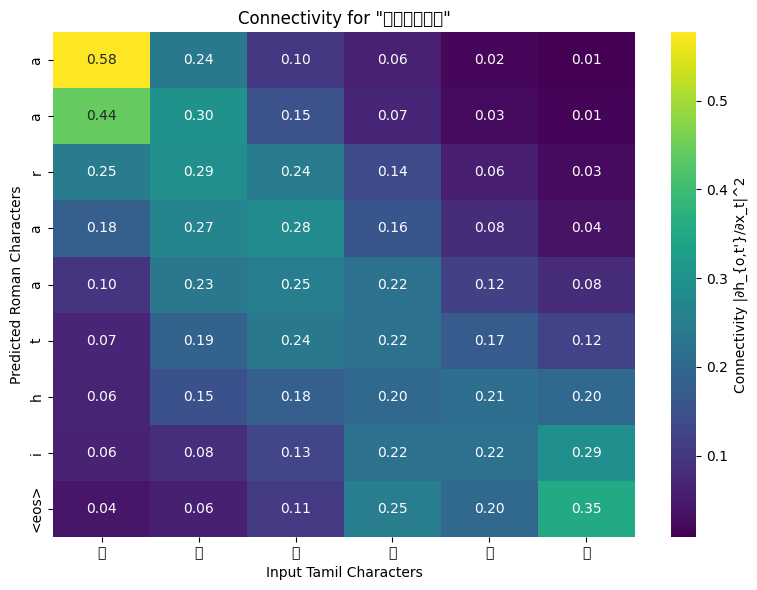

Predicted characters: ['a', 'a', 'r', 'a', 'a', 't', 'h', 'i', '<eos>']
Heatmap saved at: lstm_connectivity_heatmap.png


In [208]:
predicted_chars, heatmap_path = visualize_lstm_connectivity(
    input_word=train_df["native"][78],
    s2s_lstm = example_s2s,
    tamil_vocab=native_char2ind,
    roman_vocab=roman_char2ind,
)

print(f"Predicted characters: {predicted_chars}")
print(f"Heatmap saved at: {heatmap_path}")